<a href="https://colab.research.google.com/github/ekapolc/Pattern_2024/blob/main/HW/HW07/HW7_GANs_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 7 : GANs

In this assignment, you will learn to write an advanced PyTorch implementation concept commonly used in a complex deep learning pipeline by using GAN as a learning example.

You will also start working with more complex architectures (upsampling) and writing style (complex modules such as modulelist) for pytorch.

Every TODO is weighted equally. Optional TODO is half of a regular TODO.

## GPU test

In [1]:
!nvidia-smi

Mon Jan  6 14:30:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8             12W /  120W |      19MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Part 1 : WGAN-GP reimplementation

In this section, you are going to reimplement WGAN-GP (https://arxiv.org/pdf/1704.00028.pdf) based on the pseudocode provided in the paper to generate MNIST digit characters. Some parts are intentionally modified to discourage straight copypasting from public repositories.

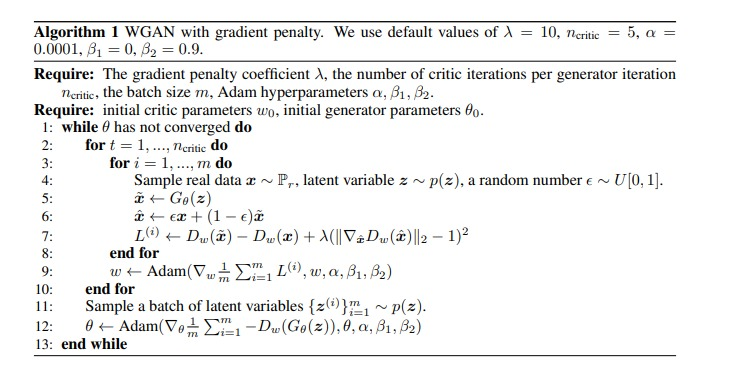

The pseudocode could be organized into two main parts: discriminator optimization in line 2-10, and generator optimization in line 11-12.

The discriminator part consists of four steps:
- Line 4: data, and noise sampling with a batch size of $m$
- Line 5-7: discriminator loss calculation
- Line 9: discriminator update
- Repeat line 4-9 for $n_{critic}$ steps

After the discriminator is updated, the generator is then updated by performing two steps:
- Line 11: noise sampling
- Line 12: generator loss calculation and update

This part is divided into four subsections: network initialization, hyperparameter initialization, data preparation, and training loop. The detail for each part will be explained in the subsections.


## Downloading MNIST dataset

The MNIST dataset contains 60,000 training digit character image (0-9) at 28x28 resolution that are normalized to [0, 1]. Given the training images, your task is to generate new training images using WGAN-GP by learning from the training distribution.

In [2]:
import torchvision.datasets as datasets
import numpy as np

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
trainX = np.array(mnist_trainset.data[..., None]).transpose(0, 3, 1, 2) / 255
print("Dataset size : ", trainX.shape)

Dataset size :  (60000, 1, 28, 28)


/tmp/ipykernel_58309/660608400.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  trainX = np.array(mnist_trainset.data[..., None]).transpose(0, 3, 1, 2) / 255


## Dataset Visualization

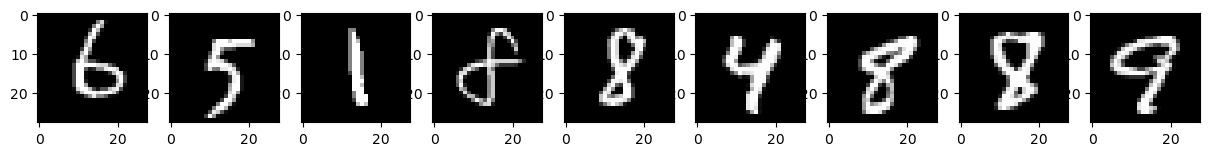

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (15,75))
for i in range(9):
  plt.subplot( int('19{}'.format(i+1)) )
  plt.imshow( trainX[np.random.randint(len(trainX))].transpose((1, 2, 0))[..., 0] , cmap = 'gray' )
plt.show()

## Generator and Discriminator network

Before training, the deep learning networks have to be initialized first. Therefore, in this part, you are going to write a generator and discriminator network based on the description provided below.

The description of the discriminator network is shown in the Table below.

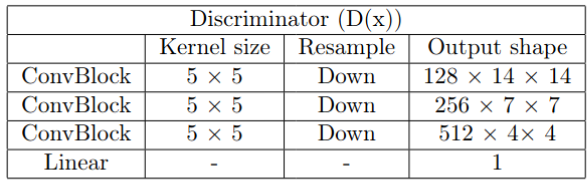

The network also has some specific requirements:
- ConvBlock is a Convolution-ReLU layer
- All ReLUs in the encoder are leaky, with a slope of 0.1




The description of the generator network is shown in the Table below.



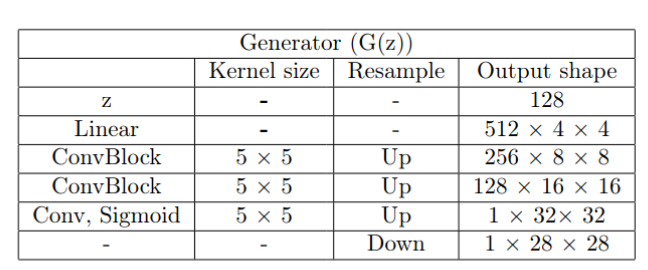

The network also has some specific requirements:
- ConvBlock is a ConvTranspose-BatchNorm-ReLU layer
- Downsampling method is bilinear interpolation (torch.nn.Upsample or torch.nn.functional.interpolate)


TODO 1: Implement a discriminator network. \
TODO 2: Implement a generator network.

In [4]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms

class Discriminator(nn.Module):
  ##TODO1 implement the discriminator (critic)
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.output_layer = nn.Linear(512 * 4 * 4, 1)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.output_layer(x)
        return x
        
class Generator(nn.Module):
    ##TODO2 implement the generator (actor)
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(128, 512 * 4 * 4)
        
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.conv_block2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.conv_block3 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )
        
        # Downsample to 1 x 28 x 28 using bilinear interpolation
        self.downsample = nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        
    def forward(self, z):
        # Project and reshape z into (512 x 4 x 4)
        x = self.linear(z)
        x = x.view(-1, 512, 4, 4)  # Reshape to 4D tensor
        
        # Pass through the ConvBlocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        # Downsample to 1 x 28 x 28
        x = self.downsample(x)
        return x
    
discriminator = Discriminator().cuda()
generator = Generator().cuda()

## Network verification

TODO 3: What is the input and output shape of the generator and discriminator network? Verify that the implemented networks are the same as the answer you have provided.

In [5]:
from torchinfo import summary
import torch

# Assuming the Generator and Discriminator classes are already implemented as provided

# Define latent dimension and input shape for Generator and Discriminator
latent_dim = 128  # Latent space dimension for Generator
input_shape = (1, 1, 28, 28)  # Input shape for Discriminator (batch size=1, grayscale image 28x28)

# Summarize the Generator model
gen_summary = summary(generator, input_data=torch.randn(1, latent_dim).cuda(), verbose=0)

# Summarize the Discriminator model
disc_summary = summary(discriminator, input_size=input_shape, verbose=0)

(gen_summary, disc_summary)


(==========================================================================================
 Layer (type:depth-idx)                   Output Shape              Param #
 Generator                                [1, 1, 28, 28]            --
 ├─Linear: 1-1                            [1, 8192]                 1,056,768
 ├─Sequential: 1-2                        [1, 256, 8, 8]            --
 │    └─ConvTranspose2d: 2-1              [1, 256, 8, 8]            3,277,056
 │    └─BatchNorm2d: 2-2                  [1, 256, 8, 8]            512
 │    └─ReLU: 2-3                         [1, 256, 8, 8]            --
 ├─Sequential: 1-3                        [1, 128, 16, 16]          --
 │    └─ConvTranspose2d: 2-4              [1, 128, 16, 16]          819,328
 │    └─BatchNorm2d: 2-5                  [1, 128, 16, 16]          256
 │    └─ReLU: 2-6                         [1, 128, 16, 16]          --
 ├─Sequential: 1-4                        [1, 1, 32, 32]            --
 │    └─ConvTranspose2d: 2-7  

## Parameter Inititalization
After the network is initialized, we then set up training hyperparameters for the training. In this part, hyperparameters have already been partially provided in the cell below, though some of them are intentionally left missing (`None`). Your task is to fill the missing parameters based on the pseudocode above.

TODO4: Initialize the missing model hyperparameters and optimizers based on the pseudocode above.

<b> Note:</b> To hasten the training process of our toy experiment, the training step and batch size is reduced to 3000 and 32, respectively.

In [6]:
NUM_ITERATION = 3000
BATCH_SIZE = 32
fixed_z = torch.randn((8, 128)).cuda()
def schedule(i):
  lr = 1e-4
  if(i > 2500): lr *= 0.1
  return lr
losses = {'D' : [None], 'G' : [None]}

## TODO4 initialize missing hyperparameter and optimzer
G_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0, 0.9))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0, 0.9))
GP_lambda = 10
n_critic = 5

## Data preparation

TODO 5: Create a dataloader that could generate the data in line 4. The dataloader should return $\mathbf{x, z, ϵ}$ with a batch size of `BATCH_SIZE`

In [7]:
# TODO5 implement dataloader
pass

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MNIST_WGANWP(Dataset):
    def __init__(self, data, latent_dim=128, p_dist="gaussian"):
        """
        Args:
            data: Input dataset (e.g., MNIST images).
            latent_dim: Dimensionality of the latent space (z).
            p_dist: Distribution to sample z and epsilon ("gaussian" or other).
        """
        self.data = data
        self.latent_dim = latent_dim
        self.p_dist = p_dist

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Real data sample
        real_x = self.data[idx]  # Fetch the real data at index `idx`
        real_x = torch.tensor(real_x, dtype=torch.float32)  # Convert to tensor
        z = torch.randn(self.latent_dim)  # Standard normal distribution
        epsilon = torch.rand(1)  # Uniform distribution

        return real_x, z, epsilon


# Instantiate the dataset
mnist_wganwp_dataset = MNIST_WGANWP(trainX, latent_dim=128)

# Create the DataLoader
wganwp_dataloader = DataLoader(
    mnist_wganwp_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Shuffle the dataset during each epoch
)


## Training loop
This section is the place where the training section starts. <b> It is highly recommended that you understand the pseudocode before performing the tasks below.</b>
To train the WGAN-GP you have to perform the following tasks: \
TODO6: Update the learning rate base on the provided scheduler. \
TODO7: Sample the data from the dataloader (Line 4). \
TODO8 : Calcualte the discriminator loss (Line 5-7).
  - In the line 7 you have to implement the gradient penalty term $\lambda \left( \lVert \nabla_{\mathbf{\hat{x}}} D_w(\mathbf{\hat{x}}) \rVert_2 - 1 \right)^2$, which is a custom gradient. You may read https://pytorch.org/docs/stable/generated/torch.autograd.grad.html to find how custom gradient is implemented.
  - HINT: Gradient norm calculation is still part of the computation graph.

  <!-- - Since the gradient of variable $\mathbf{x^{}̂ }$ has to be calculated, you have to record the operations on the tensor. Read https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html on how operations are registered. -->

TODO9: Update the discriminator loss (Line 9). \
TODO10: Calculate and update the generator loss (Line 11-12).

If your implementation is correct, the generated images should resemble an actual digit character after 500 iterations.

  0%|          | 0/3000 [00:00<?, ?it/s]

3.3515491485595703 3.3515491485595703


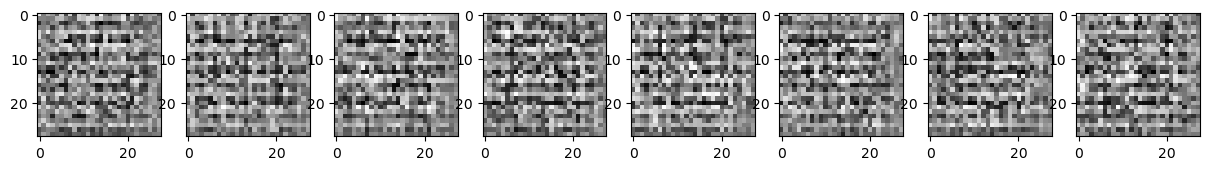

  3%|▎         | 99/3000 [00:10<04:43, 10.25it/s]

-2.70003080368042 -2.70003080368042


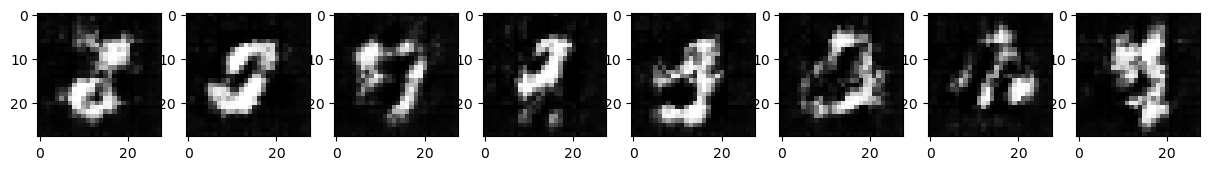

  7%|▋         | 200/3000 [00:20<05:13,  8.93it/s]

-2.1872191429138184 -2.1872191429138184


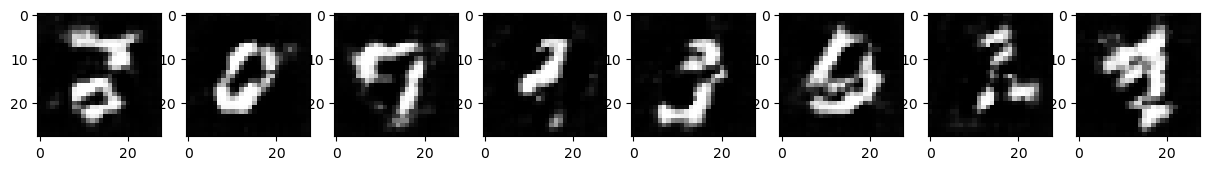

 10%|▉         | 299/3000 [00:31<04:24, 10.23it/s]

-2.0768611431121826 -2.0768611431121826


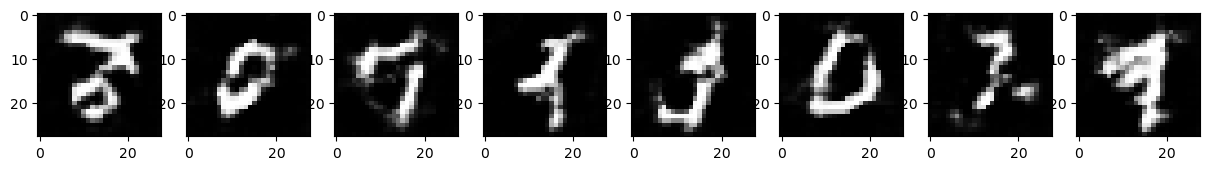

 13%|█▎        | 399/3000 [00:41<04:12, 10.30it/s]

-1.8083590269088745 -1.8083590269088745


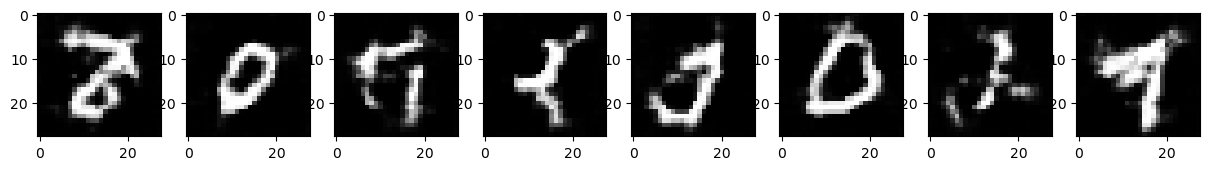

 17%|█▋        | 499/3000 [00:51<04:09, 10.01it/s]

-1.3123672008514404 -1.3123672008514404


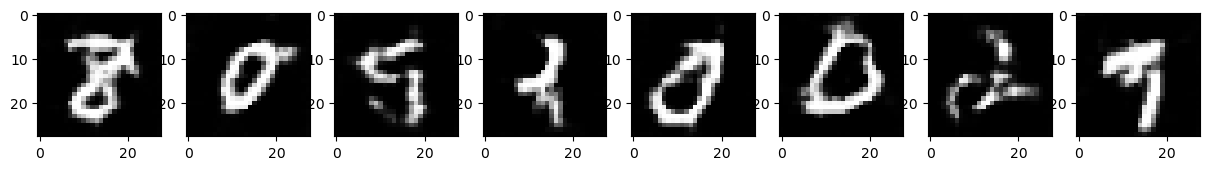

 20%|██        | 600/3000 [01:02<04:07,  9.68it/s]

-1.833609938621521 -1.833609938621521


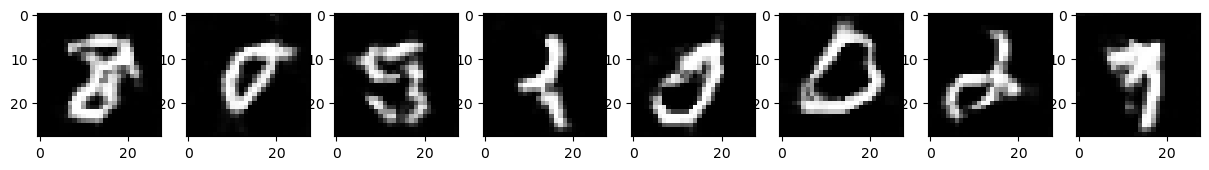

 23%|██▎       | 700/3000 [01:13<04:04,  9.40it/s]

-2.131012439727783 -2.131012439727783


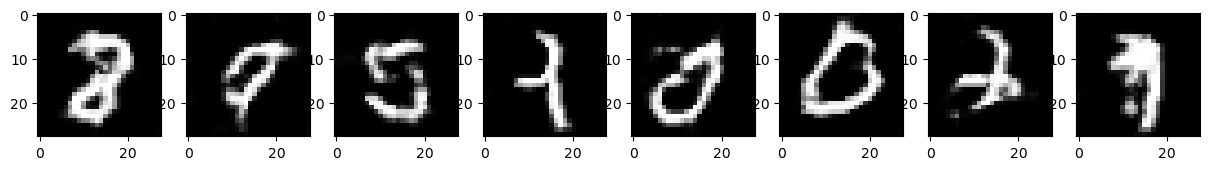

 27%|██▋       | 800/3000 [01:24<04:05,  8.95it/s]

-1.3748716115951538 -1.3748716115951538


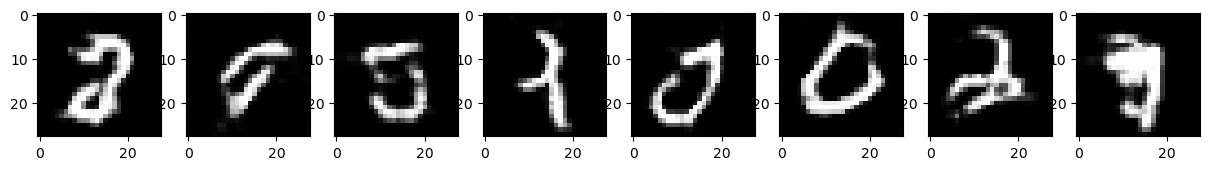

 30%|███       | 900/3000 [01:36<03:57,  8.83it/s]

-1.728325366973877 -1.728325366973877


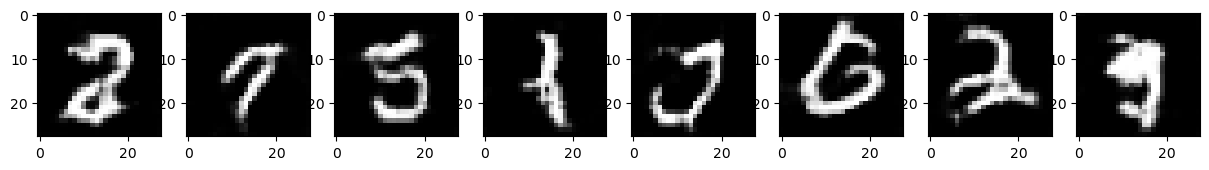

 33%|███▎      | 1000/3000 [01:47<03:36,  9.24it/s]

-1.6347750425338745 -1.6347750425338745


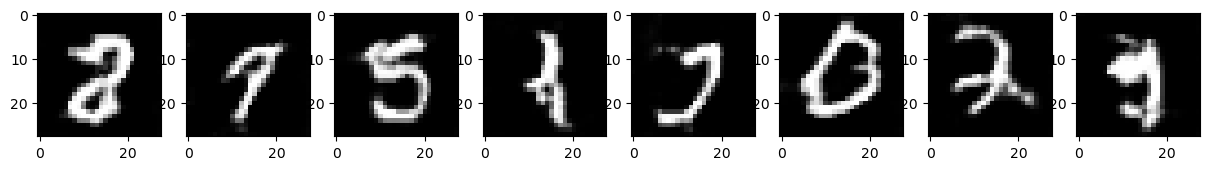

 37%|███▋      | 1100/3000 [01:59<03:41,  8.56it/s]

-1.4410068988800049 -1.4410068988800049


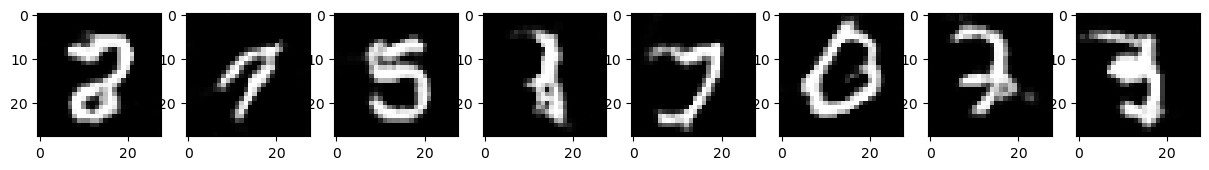

 40%|████      | 1200/3000 [02:11<03:34,  8.39it/s]

-1.2109359502792358 -1.2109359502792358


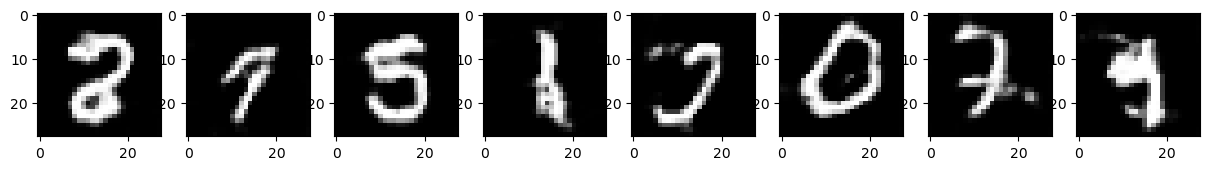

 43%|████▎     | 1300/3000 [02:22<03:16,  8.66it/s]

-1.3405941724777222 -1.3405941724777222


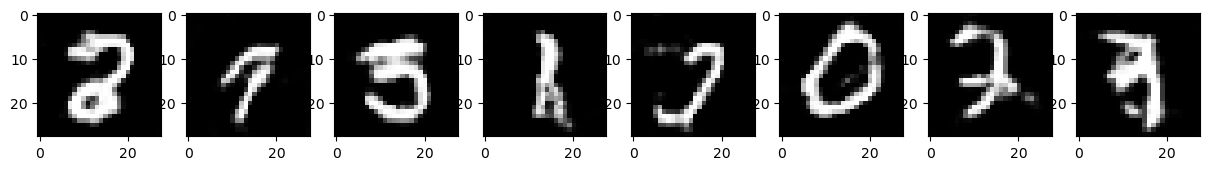

 47%|████▋     | 1400/3000 [02:34<03:00,  8.89it/s]

-1.631984829902649 -1.631984829902649


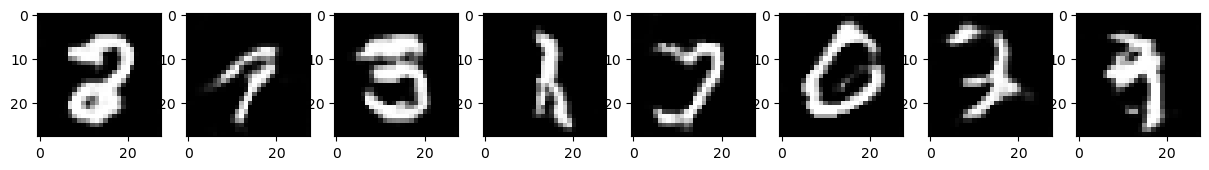

 50%|█████     | 1500/3000 [02:45<02:45,  9.04it/s]

-1.6437759399414062 -1.6437759399414062


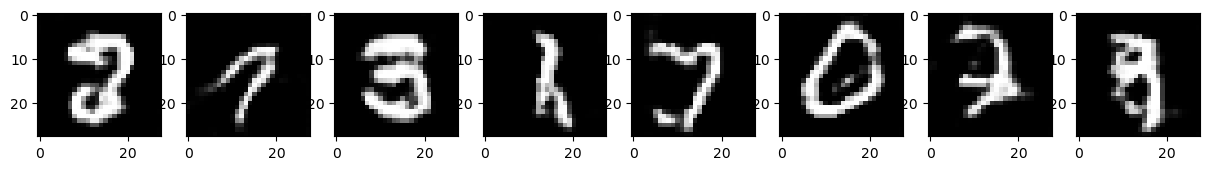

 53%|█████▎    | 1600/3000 [02:57<02:38,  8.81it/s]

-1.6510924100875854 -1.6510924100875854


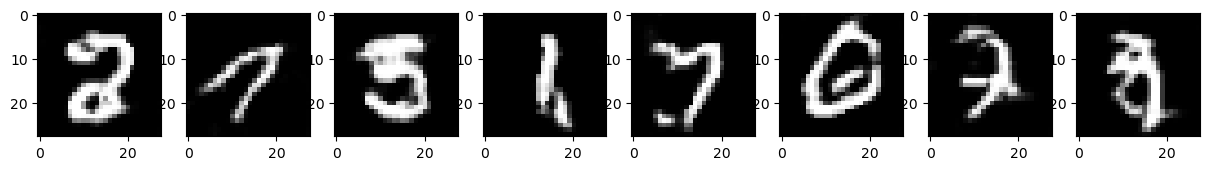

 57%|█████▋    | 1700/3000 [03:09<02:26,  8.89it/s]

-1.1835801601409912 -1.1835801601409912


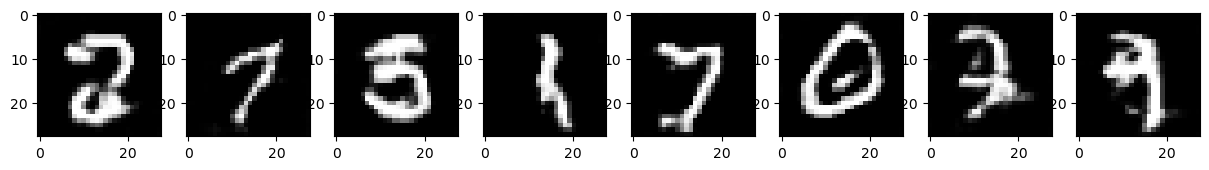

 60%|██████    | 1800/3000 [03:20<02:17,  8.71it/s]

-1.5007579326629639 -1.5007579326629639


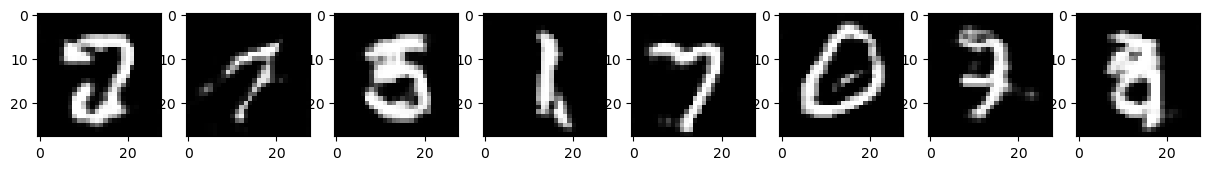

 63%|██████▎   | 1900/3000 [03:32<02:07,  8.61it/s]

-1.3474655151367188 -1.3474655151367188


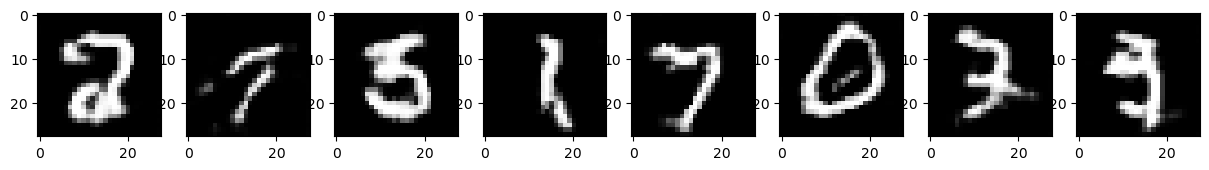

 67%|██████▋   | 2000/3000 [03:44<01:59,  8.35it/s]

-1.926375389099121 -1.926375389099121


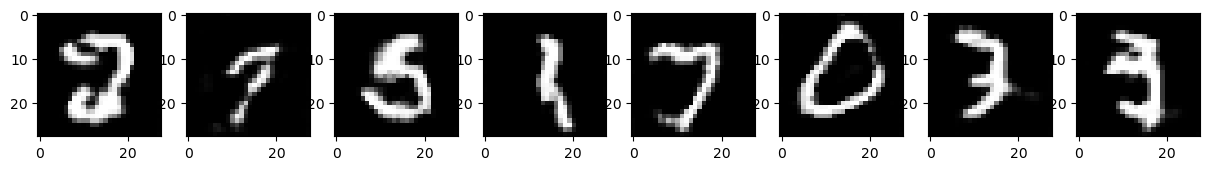

 70%|███████   | 2100/3000 [03:56<01:45,  8.57it/s]

-1.2921758890151978 -1.2921758890151978


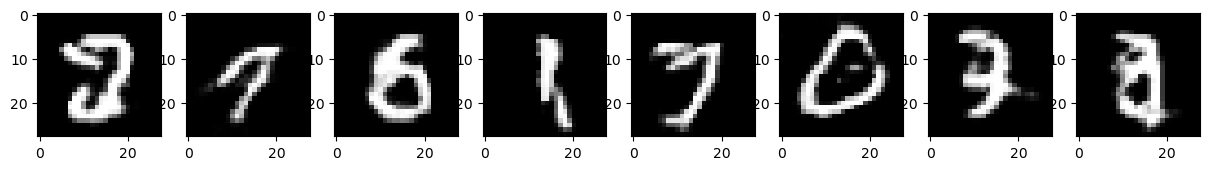

 73%|███████▎  | 2200/3000 [04:09<01:33,  8.54it/s]

-1.4117075204849243 -1.4117075204849243


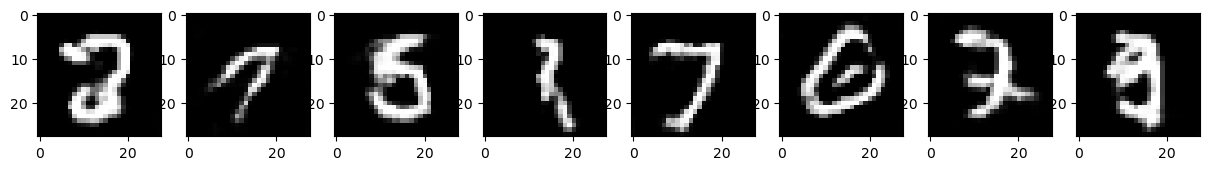

 77%|███████▋  | 2300/3000 [04:21<01:20,  8.70it/s]

-1.6555427312850952 -1.6555427312850952


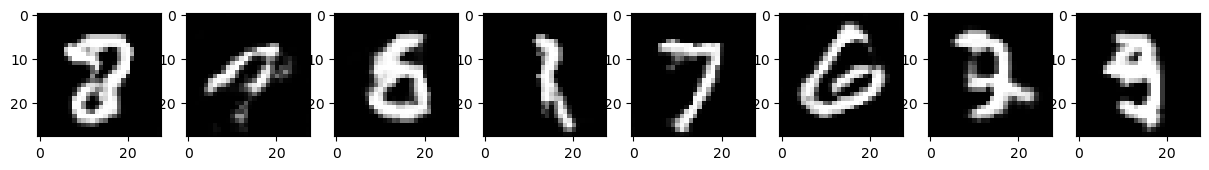

 80%|████████  | 2400/3000 [04:33<01:14,  8.03it/s]

-1.830743432044983 -1.830743432044983


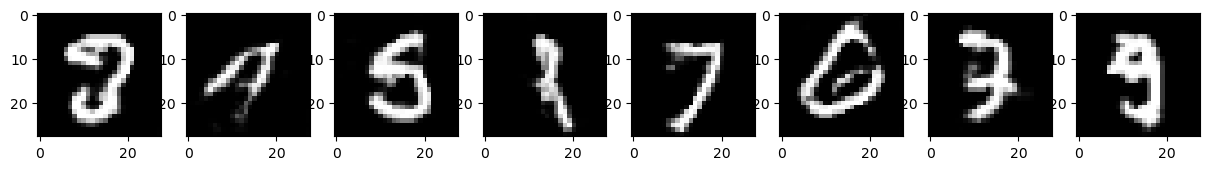

 83%|████████▎ | 2500/3000 [04:45<00:58,  8.53it/s]

-0.9211480021476746 -0.9211480021476746


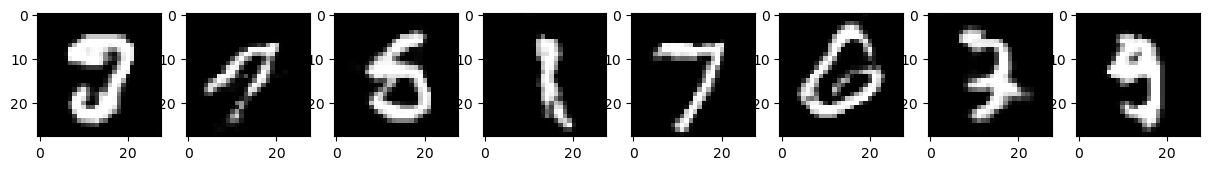

 87%|████████▋ | 2600/3000 [04:57<00:48,  8.30it/s]

-1.9246305227279663 -1.9246305227279663


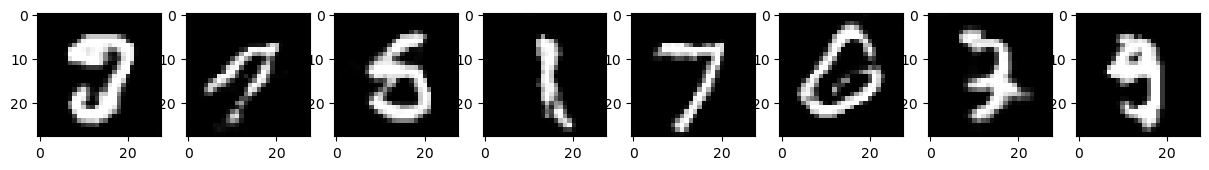

 90%|█████████ | 2700/3000 [05:09<00:35,  8.39it/s]

-1.3056138753890991 -1.3056138753890991


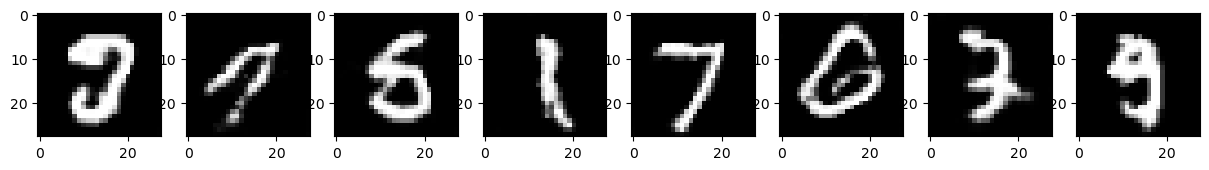

 93%|█████████▎| 2800/3000 [05:21<00:22,  8.71it/s]

-1.4868457317352295 -1.4868457317352295


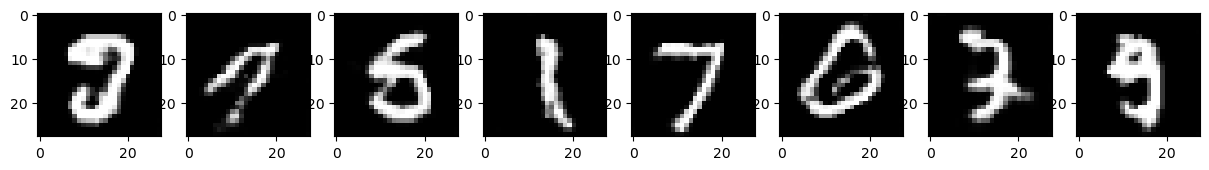

 97%|█████████▋| 2900/3000 [05:34<00:11,  8.51it/s]

-1.5264369249343872 -1.5264369249343872


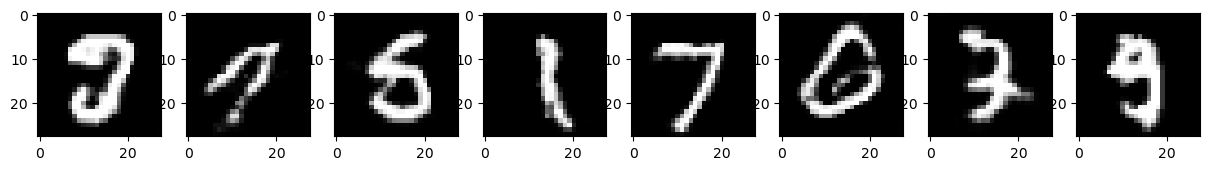

100%|██████████| 3000/3000 [05:46<00:00,  8.66it/s]


In [9]:
from tqdm import tqdm
for i in tqdm(range(NUM_ITERATION)):
  ## TODO6 update learning rate
  pass
  lr = schedule(i)

  for param_group in G_optimizer.param_groups:
      param_group['lr'] = lr
  for param_group in D_optimizer.param_groups:
      param_group['lr'] = lr

     
  for t in range(n_critic):
    ## TODO7 line 4: sample data from dataloader
    pass
    x_real, z, epsilon = next(iter(wganwp_dataloader))  # Sample one batch of data
    x_real, z, epsilon = x_real.cuda(), z.cuda(), epsilon.cuda()
    epsilon = epsilon.view(-1, 1, 1, 1)  # Ensure broadcasting
      
    ## TODO8 line5-7 : calculate discriminator loss
    pass
    x_generated = generator(z)
    x_interpolated = epsilon * x_real + (1 - epsilon) * x_generated
    x_interpolated.requires_grad_(True)

    # Discriminator outputs
    d_real = discriminator(x_real).mean()
    d_fake = discriminator(x_generated).mean()
    d_interpolated = discriminator(x_interpolated)

    # Gradient penalty
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=x_interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    # Total discriminator loss
    discriminator_loss = d_fake - d_real + GP_lambda * gradient_penalty
    
    ## TODO9 : line 9 update discriminator loss
    D_optimizer.zero_grad()
    discriminator_loss.backward()
    D_optimizer.step()
    losses['D'].append(discriminator_loss.item())
  ## TODO10 : line 11-12 calculate and update the generator loss
  pass
  z = torch.randn(BATCH_SIZE, latent_dim).cuda()  # Sample new latent vectors
  x_generated = generator(z)
  g_fake = discriminator(x_generated).mean()
  generator_loss = -g_fake
  losses['G'].append(discriminator_loss.item())
  G_optimizer.zero_grad()
  generator_loss.backward()
  G_optimizer.step()
  # Output visualization : If your reimplementation is correct, the generated images should start resembling a digit character after 500 iterations.
  if(i % 100 == 0):
    plt.figure(figsize = (15,75))
    print(losses['D'][-1], losses['G'][-1])
    with torch.no_grad():
      res = generator(fixed_z).cpu().detach().numpy()
    for k in range(8):
      plt.subplot( int('18{}'.format(k+1)) )
      plt.imshow( res[k].transpose(1, 2, 0)[..., 0], cmap = 'gray' )
    plt.show()

# Part 2 : pix2pix reimplementation (cGAN on paired image translation)

In this exercise, we are reimplementing a paired image translation model, an application of a generative adversarial network (GAN). The model we are going to implement is pix2pix (https://arxiv.org/pdf/1611.07004.pdf), one of the earliest paired image translation models based on GAN. The pipeline of pix2pix is shown in the Figure below.



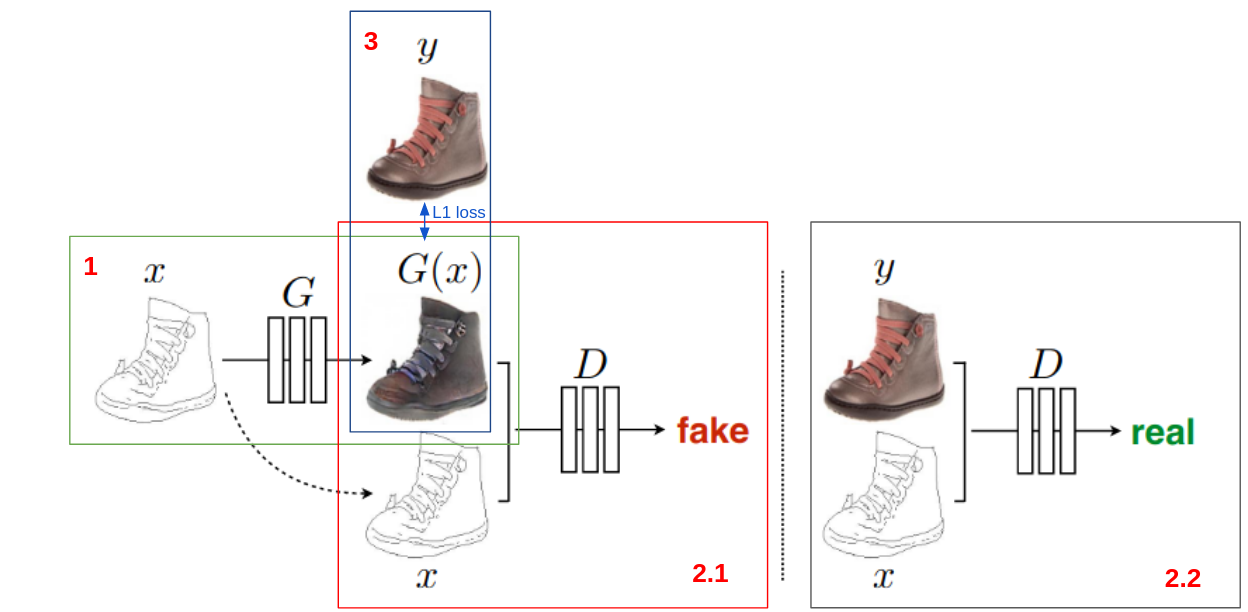

From the figure above, the pipeline consists of three main parts:

- 1. Generation phase : the generator $G$ create the generated image $G(x)$ from the given input $x$.
- 2. Discrimination phase :
    
    In step 2.1, the discriminator $D$ receives an input image $x$ and the generated image $G(x)$, then the discriminator has to learn to predict that the generated image $G(x)$ is fake. \
    In step 2.2, the discriminator $D$ receives an input image $x$ and the ground truth image $y$, then the discriminator has to learn to predict that the image $y$ is real.

- 3. Refinement phase: Refine the quality of the generated image $G(x)$ by encouraging the generated image to be close to an actual image $y$ by using L1 as an objective.

The objective of pix2pix is to train an optimal genereator $G^*$ base on the objective function : $G^* = arg min_G max_D L_{cGAN}(G, D) + \lambda L_1(G)$

- The term $arg min_G max_D L_{cGAN}(G, D)$ is the objective function of the first and second step, which is a standard cGAN loss : $L_{cGAN}(G, D) = E_{x,y}[logD(x,y)] + E_{x,z}[log(1 - D(x, G(x,z)))] $. The noise $z$ is embedded in the generator in the form of dropout.

- The term $L_1(G)$ is the objective fuction of the third step where $L_1(G) = E_{x,y,z}[||y - G(x, z)||_1]$

The subsections will explain the dataset and training setup of this exercise.

## Get dataset

In [10]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

--2025-01-06 14:38:46--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   679KB/s    in 71s     

2025-01-06 14:39:58 (418 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



## Import library

In [12]:
import cv2
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Setting up facade dataset

The dataset chosen for this exercise is the CMP Facade Database which is a pair of facade images and its segmented component stored in RGB value. The objective of this exercise is to generate a facade given its simplified segmented component. Both input and output is a 256 x 256 RGB image normalized to [-1, 1].

In [13]:
train = (np.array([cv2.imread(i) for i in glob.glob('facades/train/*')], dtype = np.float32) / 255).transpose((0, 3, 1, 2))
train = (train - 0.5) * 2 #shift from [0,1] to [-1, 1]
trainX = train[:, :, :, 256:]
trainY = train[:, :, :, :256]

val = (np.array([cv2.imread(i) for i in glob.glob('facades/val/*')], dtype = np.float32) / 255).transpose((0, 3, 1, 2))
val = (val - 0.5) * 2 #shift from [0,1] to [-1, 1]
valX = val[:, :, :, 256:]
valY = val[:, :, :, :256]

print("Input size : {}, Output size = {}".format(trainX.shape, trainY.shape))

Input size : (400, 3, 256, 256), Output size = (400, 3, 256, 256)


## Dataset  Visualization

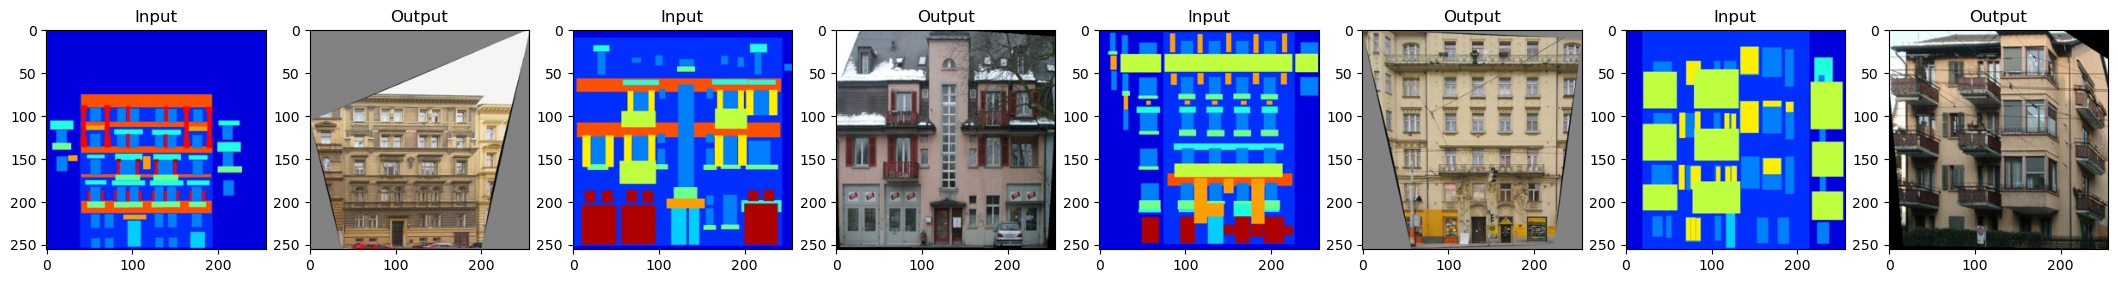

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (30,90))
for i in range(4):
  idx = np.random.randint(len(trainX))

  plt.subplot( int('19{}'.format(2*i+1)) )
  plt.title('Input')
  plt.imshow( (0.5 * trainX[idx].transpose((1, 2, 0)) + 0.5)[..., ::-1] , cmap = 'gray' )
  plt.subplot( int('19{}'.format(2*i+2)) )
  plt.title('Output')
  plt.imshow( (0.5 * trainY[idx].transpose((1, 2, 0)) + 0.5)[..., ::-1], cmap = 'gray' )
plt.show()


## <b> Note
If you have trouble understanding the instruction provided in this homework or have any ambugity about the instruction, you could also read the appendix section (section 6.1-6.2) in the paper for a detailed explanation.

## Discriminator network

In this section, we are going to implement a discriminator network of pix2pix. The description of the discriminator network is provided in the Figure below.



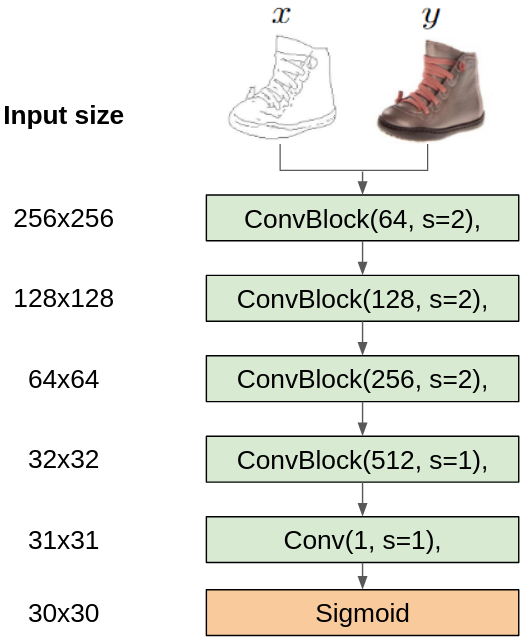

The network also has the following specific requirements:
- All convolutions are 4 × 4 spatial filters
- ConvBlock is a Convolution-InstanceNorm-ReLU layer
- InstanceNorm is not applied to the first C64 layer
- All ReLUs are leaky, with a slope of 0.2

TODO 11: Implement the discriminator network based on the description above.

TODO 12: What should be the size of the input and output of the discriminator for this task? Verify that the input and output of the implemented network are the same as the answer you have provided.

In [32]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_norm=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm = nn.InstanceNorm2d(out_channels) if apply_norm else nn.Identity()
        self.non_linear = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.non_linear(x)
        return x

class ConvTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout_rate=0.5):
        super().__init__()
        self.conv_T = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.norm = nn.InstanceNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()  # Optional dropout
        self.non_linear = nn.ReLU()

    def forward(self, x):  # Fixed typo
        x = self.conv_T(x)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.non_linear(x)
        return x


In [33]:
class Discriminator(nn.Module):
  #TODO11 implement the discriminator network
    def __init__(self):
        super().__init__()
        # First block: no InstanceNorm
        self.conv_block1 = ConvBlock(6, 64, apply_norm=False)
        # Subsequent blocks: use InstanceNorm
        self.conv_block2 = ConvBlock(64, 128)
        self.conv_block3 = ConvBlock(128, 256)
        self.conv_block4 = ConvBlock(256, 512, stride=1)  # Stride=1 for this block
        # Final Conv layer
        self.conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        # Sigmoid activation for the final output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv(x)  # Final convolution
        x = self.sigmoid(x)  # Apply Sigmoid activation
        return x

      
discriminator = Discriminator().cuda()

In [34]:
from torchinfo import summary

# Create two random tensors with shape (1, 3, 256, 256) (batch size 1, RGB images)
image1 = torch.randn(1, 3, 256, 256)  # First image sample
image2 = torch.randn(1, 3, 256, 256)  # Second image sample

# Concatenate along the channel dimension (dim=1)
discriminator_sample_input = torch.cat([image1, image2], dim=1).cuda()  # Move to GPU if necessary

# Check the shape of the input
print(discriminator_sample_input.shape)  # Should print: torch.Size([1, 6, 256, 256])

# Verify the discriminator using torchinfo
summary(discriminator, input_data=discriminator_sample_input)

torch.Size([1, 6, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 30, 30]            --
├─ConvBlock: 1-1                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         6,208
│    └─Identity: 2-2                     [1, 64, 128, 128]         --
│    └─LeakyReLU: 2-3                    [1, 64, 128, 128]         --
├─ConvBlock: 1-2                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-4                       [1, 128, 64, 64]          131,200
│    └─InstanceNorm2d: 2-5               [1, 128, 64, 64]          --
│    └─LeakyReLU: 2-6                    [1, 128, 64, 64]          --
├─ConvBlock: 1-3                         [1, 256, 32, 32]          --
│    └─Conv2d: 2-7                       [1, 256, 32, 32]          524,544
│    └─InstanceNorm2d: 2-8               [1, 256, 32, 32]          --
│    └─LeakyReLU: 2-9                    [1, 256, 32, 32]          --
├─

##  Generator network

In this section, we are going to implement a generator network of pix2pix. The generator is based on the U-NET based architecture (https://arxiv.org/abs/1505.04597). The Description of the generator network is provided in the Figure below.



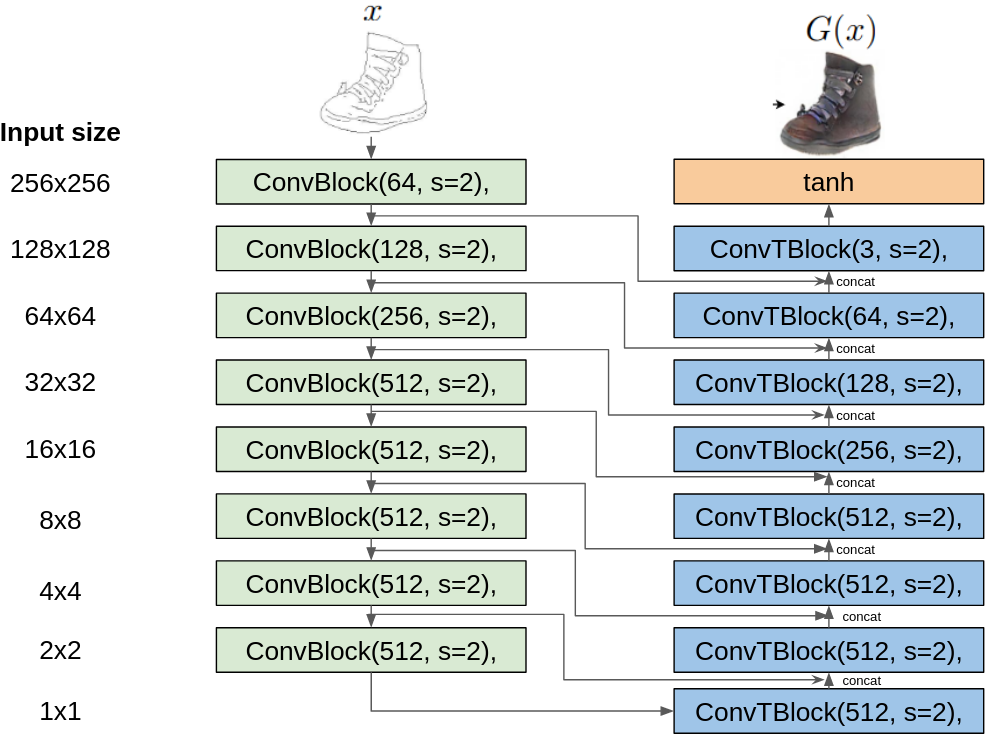

The network also has the following specific requirements:
- All convolutions are 4 × 4 spatial filters
- ConvBlock is a Convolution-InstanceNorm-ReLU layer
- ConvTBlock is a ConvolutionTranspose-InstanceNorm-DropOut-ReLU layer with a dropout rate of 50%
- InstanceNorm is not applied to the first C64 layer in the encoder
- All ReLUs in the encoder are leaky, with a slope of 0.2, while ReLUs in the decoder are not leaky



TODO 13: Implement the generator network based on the description above.

TODO 14: What should be the size of the input and output of the generator for this task? Verify that the input and output of the implemented network are the same as the answer you have provided.

In [35]:
#HINT : you could also put multiple layers in a single list using nn.ModuleList
  
class Example(nn.Module):
  def __init__(self):
    super().__init__()
    self.convs = nn.ModuleList([nn.Conv2d(25, 25, 3) for i in range(5)])
  def forward(self, x):
    for i in range(len(self.convs)):
      x = self.convs[i](x)
    return x
ex = Example().cuda()
print(ex(torch.zeros((8, 25, 32, 32)).cuda() ).shape)
# summary(ex, input_size=(1,25,128,128))

torch.Size([8, 25, 22, 22])


In [57]:
class Generator(nn.Module):
    # TODO13: Implement the generator network
    def __init__(self):
        super().__init__()
        
        # Encoder (ConvBlock)
        self.encoder_block = nn.ModuleList([
            ConvBlock(3, 64, apply_norm=False),  # No InstanceNorm for the first block
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            ConvBlock(512, 512),
            ConvBlock(512, 512),
            ConvBlock(512, 512),
            ConvBlock(512, 512, apply_norm=False),
        ])
        
        # Decoder (ConvTransposeBlock)
        self.decoder_block = nn.ModuleList([
            ConvTransposeBlock(512, 512),                 # First decoder layer
            ConvTransposeBlock(512 + 512, 512),          # Skip connection with encoder
            ConvTransposeBlock(512 + 512, 512),
            ConvTransposeBlock(512 + 512, 512),
            ConvTransposeBlock(512 + 512, 256),
            ConvTransposeBlock(256 + 256, 128),
            ConvTransposeBlock(128 + 128, 64),
            ConvTransposeBlock(64 + 64, 3),
        ])
        
        # Final activation
        self.final_activation = nn.Tanh()

    def forward(self, x):
        # Encoder pass
        encoder_output = []
        for layer in self.encoder_block:
            x = layer(x)
            encoder_output.append(x)
        
        # Decoder pass
        y = self.decoder_block[0](x)  # First decoder block
        for layer_index in range(1, len(self.decoder_block)):
            skip_connection = encoder_output[-(layer_index + 1)]  # Get corresponding encoder output
            y = self.decoder_block[layer_index](torch.cat([y, skip_connection], dim=1))  # Concatenate along channel dimension
        
        # Apply final activation
        y = self.final_activation(y)
        return y


# Instantiate and move the generator to GPU
generator = Generator().cuda()

In [58]:
#TODO14 verify the generator
# Create two random tensors with shape (1, 3, 256, 256) (batch size 1, RGB images)
sample_image = torch.randn(32, 3, 256, 256).cuda()  # image sample
# Check the shape of the input
print(sample_image.shape)  # Should print: torch.Size([1, 6, 256, 256])

# Verify the discriminator using torchinfo
summary(generator, input_data=sample_image)

torch.Size([32, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 256, 256]         --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        3,136
│    │    └─Identity: 3-2                [32, 64, 128, 128]        --
│    │    └─LeakyReLU: 3-3               [32, 64, 128, 128]        --
│    └─ConvBlock: 2-2                    [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-4                  [32, 128, 64, 64]         131,200
│    │    └─InstanceNorm2d: 3-5          [32, 128, 64, 64]         --
│    │    └─LeakyReLU: 3-6               [32, 128, 64, 64]         --
│    └─ConvBlock: 2-3                    [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-7                  [32, 256, 32, 32]         524,544
│    │    └─InstanceNorm2d: 3-8          [32, 256, 32, 32]         --
│ 

## Data preparation
After the model is initialized, we then create a dataloader to sample the training data. In this paper, to sample the training data, you have to sequentially perform the following steps :

1. Randomly sample the data from the training set
2. Resizing both input and target to 286 × 286.
3. Randomly cropping back both images to size 256 × 256.
4. Random mirroring the images


TODO15: Implement a dataloader based on the description above. You are allowed to use the function in torchvision.transforms (https://pytorch.org/vision/main/transforms.html).




In [ ]:
# TODO15 implement a dataloader
from torchvision.transforms import v2

class CMPFacadePix2Pix(Dataset):
    def __init__(self,X, Y,transforms=None):
        self.X = X
        self.Y = Y
        self.transforms = transforms
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        if self.transforms is not None:
            x = self.transforms(x)
            y = self.transforms(y)
        return x, y

transforms = v2.Compose([
    v2.Resize(286,286),
    v2.RandomResizedCrop(size=(256,256)),
    v2.RandomHorizontalFlip(),
])

torch.Size([1, 3, 256, 256])


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

### Dataloader verification

TODO16: Show that the implemented dataloader is working as intended. For instance, are both input and output are flipped and cropped correctly? To obtain a full score, you have to show at least eight data points.

In [ ]:
#TODO16 show that the dataloader is working properly
pass

## Parameter Initialization
Model hyperparameters and optimizers have already been prepared.

In [ ]:
import torch.optim as optim
from tqdm import tqdm
lr = 2e-4
LAMBDA = 100
BATCH_SIZE = 1
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.999))

## Training loop
The training process has the following specific requirements:
- The objective is divided by 2 while optimizing $D$, which slows down the rate at which $D$ learns relative to $G$.
- This paper trains the generator $G$ to maximize  $logD(x, G(x,z))$ instead of minimizing $log(1 - D(x, G(x,z)))$ as the latter term does not provide sufficient gradient.

TODO17: Sample the data using the dataloader. \
TODO18: Calculate the discriminator loss and update the discriminator.
- During the update, the loss term $log(1 - D(x, G(x,z)))$ contains both generator and discriminator. However, we only want to update the discriminator. Therefore, you have to detach the input from the generator graph first. Read https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html for additional detail. \

TODO19: Calculate the generator loss and update the generator.

<b> HINT</b> \
Hint 1: If you are struggling with this part, you could also read the PyTorch DCGAN tutorial as a guideline (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

Hint 2: You could remove the L1 loss while debugging since the generator $G$ could still generate the synthetic image even if the L1 loss is removed, though at the cost of increasing image artifacts.

<b> Note</b> \
The training schedule in this homework is only one eighth of the orignal schedule. It is expected that the generated image quality is worse than the one shown in the paper. Nevertheless, the generated facade should still resemble an actual one.

In [ ]:
losses = {'D' : [None], 'G' : [None]}

for i in tqdm(range(20001)):
  #TODO17 sample the data from the dataloader
  pass
  #TODO18 calculate the discriminator loss and update the discriminator
  pass
  #TODO19 calculate the generator loss and update the generator
  pass
  # Output visualization : If your reimplementation is correct, the generated images should start resembling a facade after 2,500 iterations
  if(i % 2500 == 0):
    with torch.no_grad():
      print(losses['D'][-1], losses['G'][-1])
      plt.figure(figsize = (40, 16))
      gs1 = gridspec.GridSpec(4, 4)
      gs1.update(wspace=0.025)

      sampleX_vis = 0.5 * valX[:16][:, ::-1, :, :] + 0.5
      sampleY = 0.5 * valY[:16][:, ::-1, :, :] + 0.5
      sampleX = torch.tensor(valX[:16]).cuda()
      pred_val = 0.5 * generator(sampleX).cpu().detach().numpy()[:, ::-1, :, :] + 0.5
      vis = np.concatenate([sampleX_vis, sampleY, pred_val], axis = 3)
      for i in range(vis.shape[0]):
        ax1 = plt.subplot(gs1[i])
        plt.title('Input / GT / predicted')
        plt.axis('off')
        plt.imshow( vis[i].transpose(1, 2, 0) )
      plt.show()


## (Optional)

Combine the WGAN-GP loss with the pix2pix objective.

In [ ]:
pass